In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.metrics import f1_score

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")

    # Replace all white pixels (value > 250) with black
    image[image > 250] = 0

    # Detect and remove white borders
    _, thresh = cv2.threshold(image, 240, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find all non-white pixels and get their coordinates
    non_white_pixels = np.where(thresh < 240)

    if non_white_pixels[0].size == 0 or non_white_pixels[1].size == 0:
        raise ValueError("No relevant pixels found in the image.")

    # Get the smallest and largest x and y coordinates and use them to create the bounding box
    y_min, y_max = np.min(non_white_pixels[0]), np.max(non_white_pixels[0])
    x_min, x_max = np.min(non_white_pixels[1]), np.max(non_white_pixels[1])

    # Crop the image to the bounding box of all non-white pixels
    image = image[y_min:y_max+1, x_min:x_max+1]

    # Noise reduction using median blur, bilateral filter, and non-local means denoising
    image_median = cv2.medianBlur(image, 5)
    image_bilateral = cv2.bilateralFilter(image_median, 9, 75, 75)
    image_denoised = cv2.fastNlMeansDenoising(image_bilateral, h=30)

    # Wavelet denoising
    coeffs = pywt.wavedec2(image_denoised, 'db1', level=2)
    coeffs[1:] = [tuple(pywt.threshold(i, value=10, mode='soft') for i in level) for level in coeffs[1:]]
    image_wavelet_denoised = pywt.waverec2(coeffs, 'db1')

    # Normalize and expand dimensions
    image_wavelet_denoised = np.expand_dims(image_wavelet_denoised, axis=-1)
    image_wavelet_denoised = np.expand_dims(image_wavelet_denoised, axis=0)
    image_wavelet_denoised = image_wavelet_denoised.astype('float32') / 255.0

    return image, image_wavelet_denoised

def binary_mask(image):
    # Convert the processed image to uint8
    image_uint8 = (image * 255).astype(np.uint8).squeeze()

    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image_uint8, (5, 5), 0)

    # Apply binary thresholding with Otsu's method
    _, binary_image = cv2.threshold(blurred_image, 62.5, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def canny_edge_detection(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

def extract_highest_y(edges):
    height, width = edges.shape
    highest_y_values = np.full(width, height)  # Initialize with maximum Y values (bottom of image)

    for x in range(width):
        column = edges[:, x]
        y_indices = np.where(column > 0)[0]
        if y_indices.size > 0:
            highest_y = y_indices.min()  # Get the highest (minimum) Y value
            highest_y_values[x] = highest_y  # Store the highest Y value

    return highest_y_values

def plot_highest_y_on_edges(edges, highest_y_values):
    height, width = edges.shape
    output_image = np.zeros_like(edges)

    for x, y in enumerate(highest_y_values):
        if y < height:  # Ensure we don't plot outside the image
            output_image[y, x] = 255  # Plot highest Y values in white

    return output_image

def extract_top_line(highest_y_values):
    # Create an image with the top line plotted
    height = np.max(highest_y_values) + 1  # Increase height to account for boldness
    width = len(highest_y_values)
    top_line_image = np.zeros((height, width), dtype=np.uint8)

    # Draw the top line, making it bolder
    for x, y in enumerate(highest_y_values):
        if y < height - 2:  # Ensure we don't plot outside the image
            cv2.line(top_line_image, (x, y), (x, y + 2), 255, 2)  # Plot bold line in white

    return top_line_image

def concatenate_paths(base_path, filenames):
    return [os.path.join(base_path, filename) for filename in filenames]

def calculate_f1_score(ground_truth_image, predicted_image):
    # Apply a binary threshold to both images
    _, ground_truth_binary = cv2.threshold(ground_truth_image, 127, 255, cv2.THRESH_BINARY)
    _, predicted_binary = cv2.threshold(predicted_image, 127, 255, cv2.THRESH_BINARY)
    
    

    # Calculate the F1 score
    f1 = f1_score(ground_truth_binary, predicted_binary, pos_label=255, average='binary')

    
    return f1

def process_and_visualize_images(test_image_paths, eval_image_paths):
    f1_scores = []

    for test_image_path, eval_image_path in zip(test_image_paths, eval_image_paths):
        # Preprocess the image
        original_image, preprocessed_image = preprocess_image(test_image_path)

        # Apply binary masking
        binary_image = binary_mask(preprocessed_image)

        # Apply Canny edge detection
        edges = canny_edge_detection(binary_image)

        # Extract highest Y value edges
        highest_y_values = extract_highest_y(edges)

        # Plot highest Y values on the edges image
        highest_y_image = plot_highest_y_on_edges(edges, highest_y_values)

        # Extract and plot only the top line
        # Extract for evaluation
        top_line_image = extract_top_line(highest_y_values)

         # Load ground truth image
        ground_truth_image = cv2.imread(eval_image_path, cv2.IMREAD_GRAYSCALE)
        if ground_truth_image is None:
            raise FileNotFoundError(f"Ground truth image at path {eval_image_path} not found.")

        # Resize predicted_image to match ground_truth_image
        if ground_truth_image.shape != top_line_image.shape:
            predicted_image = cv2.resize(top_line_image, 
                                         (ground_truth_image.shape[1], ground_truth_image.shape[0]))
        else: 
            predicted_image = top_line_image

        # Flatten the images
        ground_truth_flat = ground_truth_image.flatten()
        predicted_flat = predicted_image.flatten()
        
        # Calculate F1 score
        f1 = calculate_f1_score(ground_truth_flat, predicted_flat)
        f1_scores.append(f1)

        fig, axs = plt.subplots(1, 6, figsize=(25, 5), sharey=True)
        
        axs[0].imshow(original_image, cmap='gray')
        axs[0].set_title('Original Image')

        axs[1].imshow(binary_image, cmap='gray')
        axs[1].set_title('Binary Mask')

        axs[2].imshow(edges, cmap='gray')
        axs[2].set_title('Canny Edges')

        axs[3].imshow(highest_y_image, cmap='gray')
        axs[3].set_title('Highest Y Values')

        axs[4].imshow(ground_truth_image, cmap='gray')
        axs[4].set_title('Ground Truth')

        axs[5].imshow(top_line_image, cmap='gray')
        axs[5].set_title('Top Line')
        axs[5].text(10, 20, f'F1: {f1:.2f}', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

        plt.show()
        
        

    # Print the average F1 score
    print(f"Average F1 Score: {np.mean(f1_scores):.2f}")

# Example usage
test_base_path = 'DATA_OCT'
eval_base_path1 = 'BOOM_ILM'
eval_base_path2 = 'Mighty_ILM1'

# Lists of filenames for test and evaluation datasets
test_filenames = [
    'dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09.jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg',
    'img_17.jpeg', 'img_18.jpeg', 'img_19.jpeg',
    'img_21.jpeg', 'img_23.jpeg', 'img_24.jpeg',
    'img_25.jpeg'
]



eval_filenamesBoom = [
    'dr_test_1190_NV.png', 'img_02.png', 'img_04.png',
    'img_05.png', 'img_06.png', 'img_07.png',
    'img_08.png', 'img_09 (1).PNG', 'img_10.png',
    'img_11.png', 'img_15.png', 'img_16.png',
    'img_17.png', 'img_18.png', 'img_19.png',
    'img_21.png', 'img_23.png', 'img_24.png',
    'img_25.png'
]

eval_filenamesMighty = [
    'dr_test_1190_NV_ILM.png', 'img_02_ILM.png', 'img_04_ILM.png',
    'img_05_ILM.png', 'img_06_ILM.png', 'img_07_ILM.png',
    'img_08_ILM.png', 'img_09_ILM.png', 'img_10_ILM.png',
    'img_11_ILM.png', 'img_15_ILM.png', 'img_16_ILM.png',
    'img_17_ILM.png', 'img_18_ILM.png', 'img_19_ILM.png',
    'img_21_ILM.png', 'img_23_ILM.png', 'img_24_ILM.png',
    'img_25_ILM.png'
]

test_image_paths = concatenate_paths(test_base_path, test_filenames)
eval_image_paths1 = concatenate_paths(eval_base_path1, eval_filenamesBoom)
# eval_image_paths2 = concatenate_paths(eval_base_path2, eval_filenamesMighty)

# Combine and process both test and evaluation image paths
process_and_visualize_images(test_image_paths, eval_image_paths1)


In [55]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.metrics import f1_score

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")
    
    # Replace white pixels with black
    image[image > 250] = 0
    
    # Detect and remove white borders
    _, thresh = cv2.threshold(image, 240, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    non_white_pixels = np.where(thresh < 240)

    if non_white_pixels[0].size == 0 or non_white_pixels[1].size == 0:
        raise ValueError("No relevant pixels found in the image.")

    # Crop image to non-white pixels
    y_min, y_max = np.min(non_white_pixels[0]), np.max(non_white_pixels[0])
    x_min, x_max = np.min(non_white_pixels[1]), np.max(non_white_pixels[1])
    image = image[y_min:y_max+1, x_min:x_max+1]

    # Apply noise reduction
    image_denoised = cv2.fastNlMeansDenoising(
        cv2.bilateralFilter(
            cv2.medianBlur(image, 5), 9, 75, 75
        ), h=30
    )

    # Apply wavelet denoising
    coeffs = pywt.wavedec2(image_denoised, 'db1', level=2)
    coeffs[1:] = [tuple(pywt.threshold(i, value=10, mode='soft') for i in level) for level in coeffs[1:]]
    image_wavelet_denoised = pywt.waverec2(coeffs, 'db1')

    # Normalize and expand dimensions
    image_wavelet_denoised = np.expand_dims(image_wavelet_denoised, axis=(0, -1)).astype('float32') / 255.0
    return image, image_wavelet_denoised

def binary_mask(image):
    # Convert to uint8, apply Gaussian blur, and binary thresholding
    image_uint8 = (image * 255).astype(np.uint8).squeeze()
    blurred_image = cv2.GaussianBlur(image_uint8, (5, 5), 0)
    _, binary_image = cv2.threshold(blurred_image, 62.5, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def canny_edge_detection(image):
    return cv2.Canny(image, 100, 200)

def extract_highest_y(edges):
    height, width = edges.shape
    highest_y_values = np.full(width, height)  # Initialize with bottom of image

    for x in range(width):
        column = edges[:, x]
        y_indices = np.where(column > 0)[0]
        if y_indices.size > 0:
            highest_y_values[x] = y_indices.min()
    
    return highest_y_values

def plot_highest_y_on_edges(edges, highest_y_values, base_thickness=8):
    # Create an output image with the same dimensions as the input edges
    output_image = np.zeros_like(edges)
    
    # Calculate dynamic thickness based on image height
    image_height, _ = edges.shape
    dynamic_thickness = int(base_thickness * (image_height / 640))  # Scale thickness based on image height

    # Iterate through each x-coordinate
    for x, y in enumerate(highest_y_values):
        if y < edges.shape[0]:
            # Draw a thicker line by using a thicker line width
            start_y = max(0, y - dynamic_thickness // 2)
            end_y = min(edges.shape[0], y + dynamic_thickness // 2 + 1)
            output_image[start_y:end_y, x] = 255
    
    return output_image



def concatenate_paths(base_path, filenames):
    return [os.path.join(base_path, filename) for filename in filenames]

def pad_to_size(image, target_shape):
    target_height, target_width = target_shape
    height, width = image.shape[:2]

    # Create a canvas with target size and place the image in the center
    padded_image = np.zeros((target_height, target_width), dtype=np.uint8)
    top = (target_height - height) // 2
    left = (target_width - width) // 2
    padded_image[top:top + height, left:left + width] = image

    return padded_image

def calculate_f1_score(ground_truth_image, predicted_image):
    _, ground_truth_binary = cv2.threshold(ground_truth_image, 127, 255, cv2.THRESH_BINARY)
    _, predicted_binary = cv2.threshold(predicted_image, 127, 255, cv2.THRESH_BINARY)

    # Visualize for debugging
    # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # axs[0].imshow(ground_truth_binary, cmap='gray')
    # axs[0].set_title('Ground Truth Binary')
    # axs[0].axis('on')

    # axs[1].imshow(predicted_binary, cmap='gray')
    # axs[1].set_title('Predicted Binary')
    # axs[1].axis('on')

    # axs[2].imshow(predicted_image, cmap='gray')
    # axs[2].set_title('Predicted Original')
    # axs[2].axis('on')

    # plt.tight_layout()
    # plt.show()

    return f1_score(ground_truth_binary.flatten(), predicted_binary.flatten(), pos_label=255, average='binary')

def process_and_visualize_images(test_image_paths, eval_image_paths):
    f1_scores = []

    for test_image_path, eval_image_path in zip(test_image_paths, eval_image_paths):
        # Preprocess the image
        original_image, preprocessed_image = preprocess_image(test_image_path)
        binary_image = binary_mask(preprocessed_image)
        edges = canny_edge_detection(binary_image)
        highest_y_values = extract_highest_y(edges)
        highest_y_image = plot_highest_y_on_edges(edges, highest_y_values)
        

        # Load ground truth image
        ground_truth_image = cv2.imread(eval_image_path, cv2.IMREAD_GRAYSCALE)
        if ground_truth_image is None:
            raise FileNotFoundError(f"Ground truth image at path {eval_image_path} not found.")

        # Pad images to ensure the same size
        max_height = max(ground_truth_image.shape[0], highest_y_image.shape[0])
        max_width = max(ground_truth_image.shape[1], highest_y_image.shape[1])

        ground_truth_padded = pad_to_size(ground_truth_image, (max_height, max_width))
        top_line_padded = pad_to_size(highest_y_image, (max_height, max_width))

        # Calculate F1 score
        f1 = calculate_f1_score(ground_truth_padded, top_line_padded)
        f1_scores.append(f1)

        # Plot results
        # fig, axs = plt.subplots(1, 2)
        # axs[0].imshow(top_line_padded, cmap='gray')
        # axs[0].set_title('Top Line')
        # axs[0].text(10, 20, f'F1: {f1:.2f}', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        # axs[0].axis('on')

        # axs[1].imshow(ground_truth_padded, cmap='gray')
        # axs[1].set_title('Ground Truth')
        # axs[1].axis('on')

        # plt.tight_layout()
        # plt.show()

        # axs[2].imshow(highest_y_image, cmap='gray')
        # axs[2].set_title('Highest Y Values')
        # axs[2].axis('on')


    # Print the average F1 score
    print(f"Average F1 Score: {np.mean(f1_scores):.2f}")

# Example usage
test_base_path = 'DATA_OCT'
eval_base_path1 = 'BOOM_ILM'

test_filenames = [
    'dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09.jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg',
    'img_17.jpeg', 'img_18.jpeg', 'img_19.jpeg',
    'img_21.jpeg', 'img_23.jpeg', 'img_24.jpeg',
    'img_25.jpeg'
]

eval_filenamesBoom = [
    'dr_test_1190_NV.png', 'img_02.png', 'img_04.png',
    'img_05.png', 'img_06.png', 'img_07.png',
    'img_08.png', 'img_09 (1).PNG', 'img_10.png',
    'img_11.png', 'img_15.png', 'img_16.png',
    'img_17.png', 'img_18.png', 'img_19.png',
    'img_21.png', 'img_23.png', 'img_24.png',
    'img_25.png'
]

test_image_paths = concatenate_paths(test_base_path, test_filenames)
eval_image_paths1 = concatenate_paths(eval_base_path1, eval_filenamesBoom)

process_and_visualize_images(test_image_paths, eval_image_paths1)


Average F1 Score: 0.60


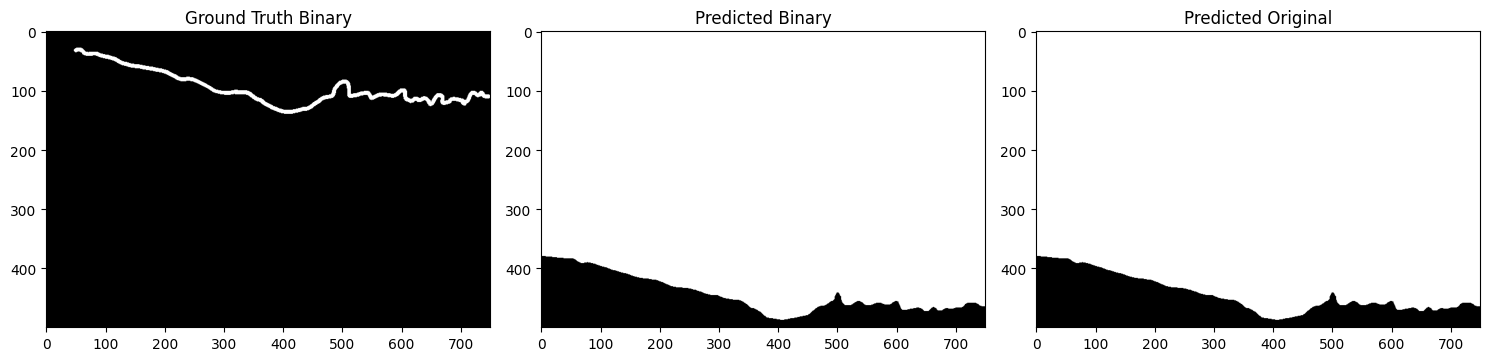

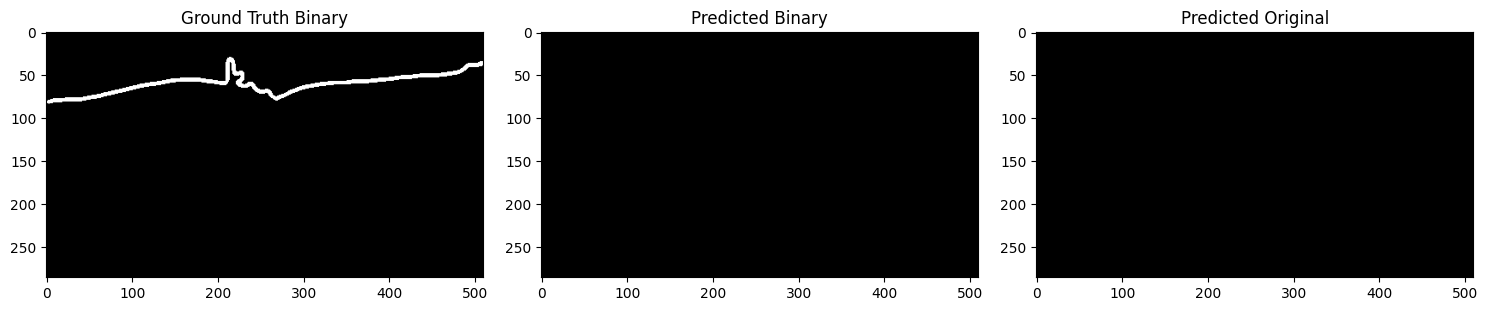

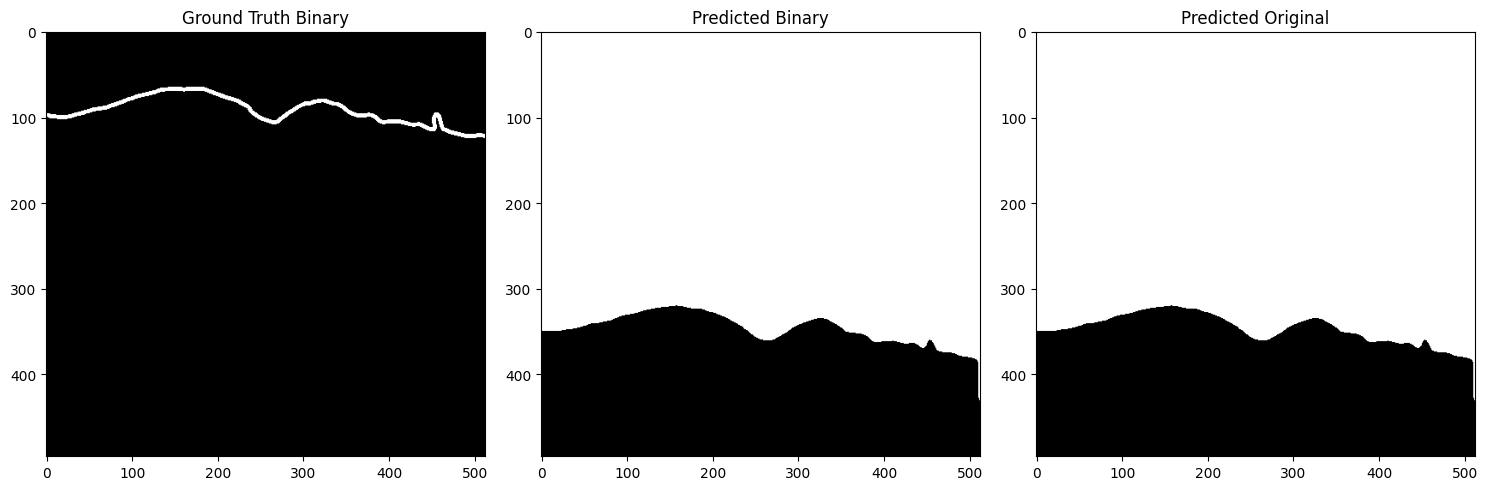

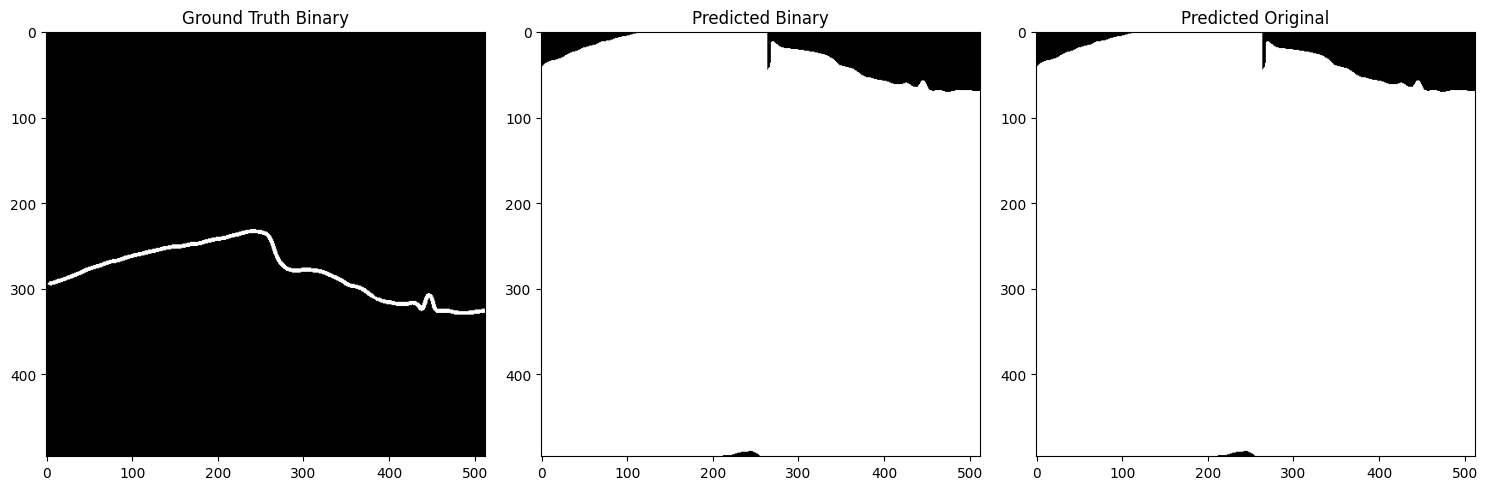

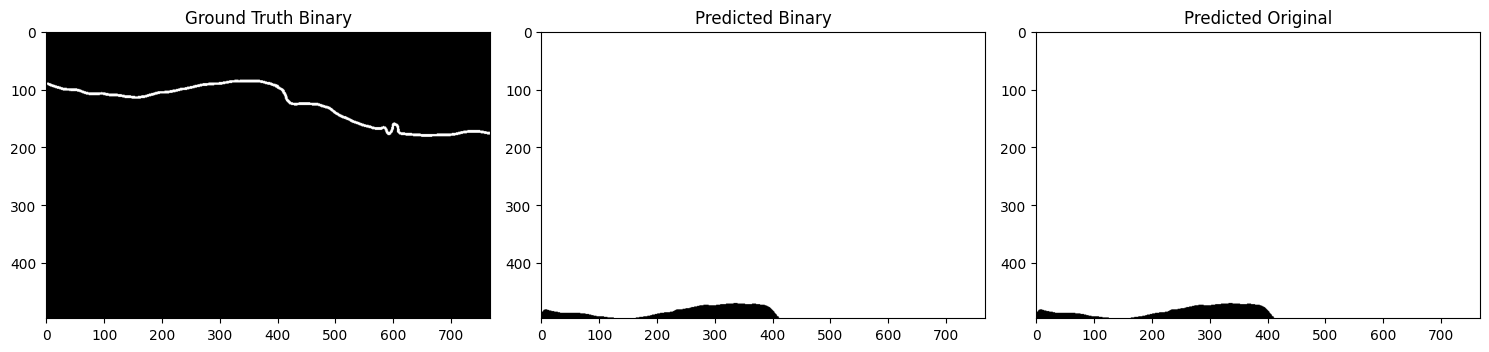

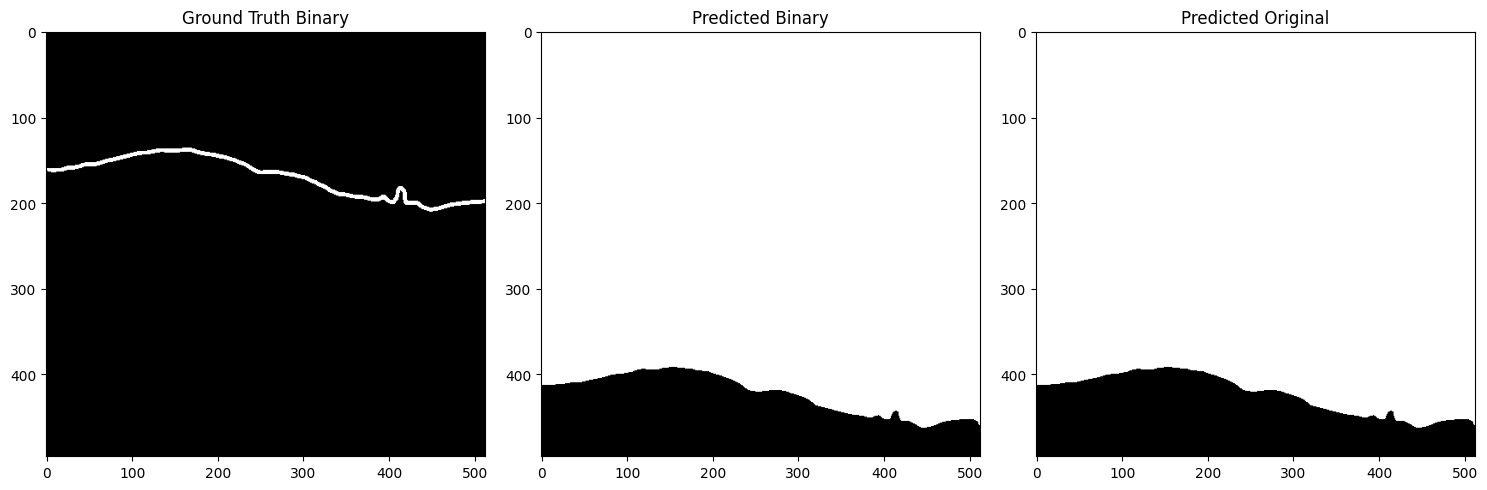

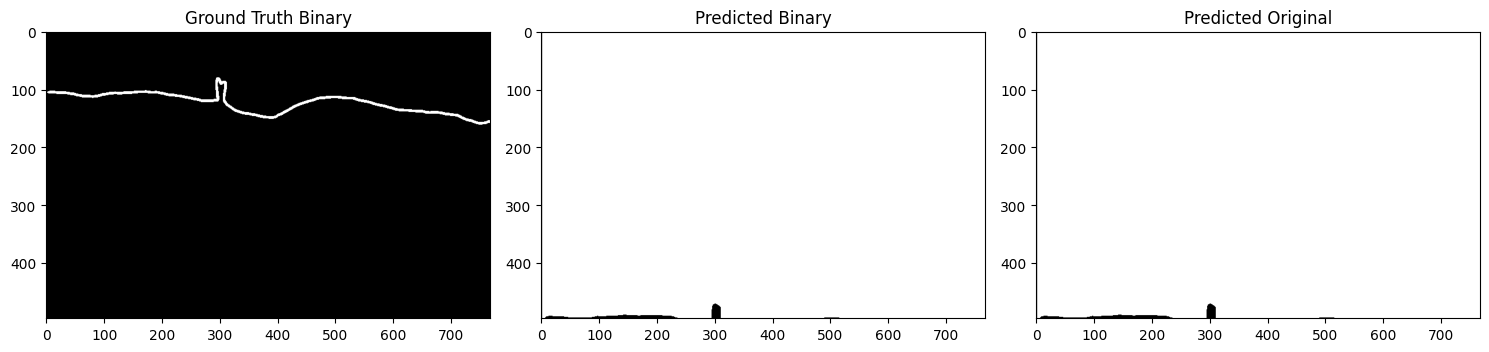

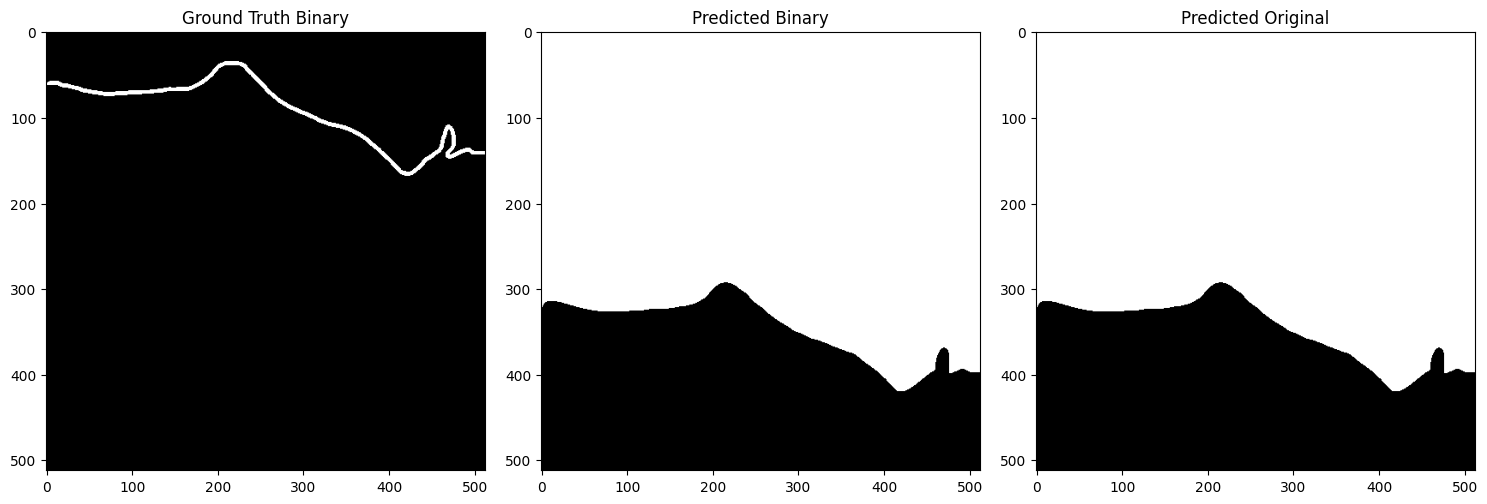

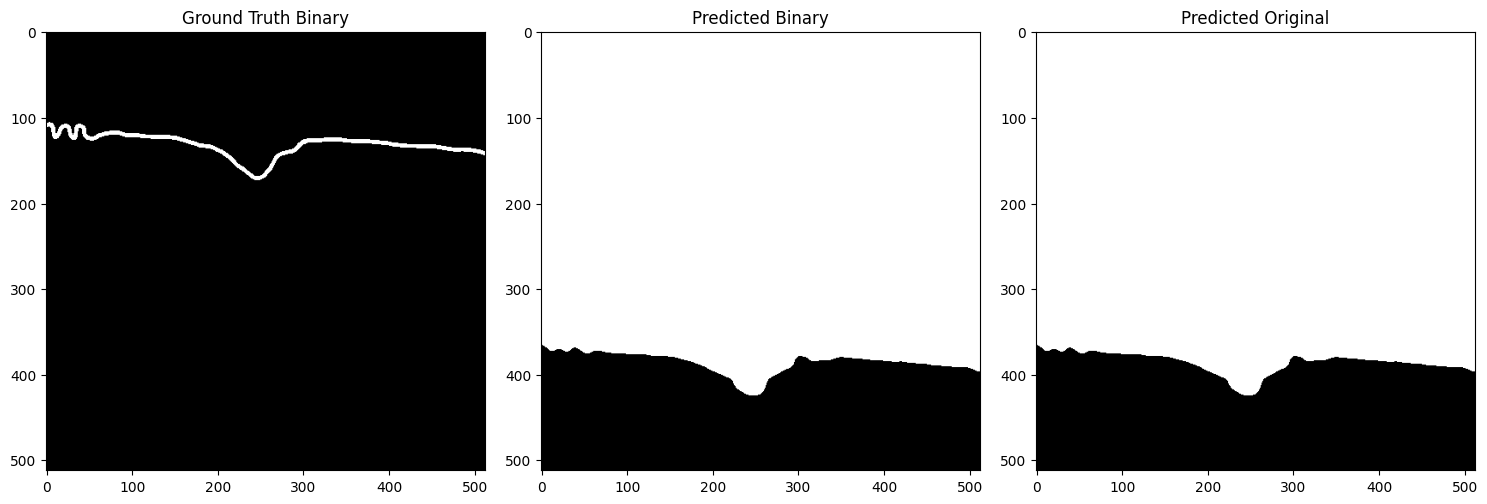

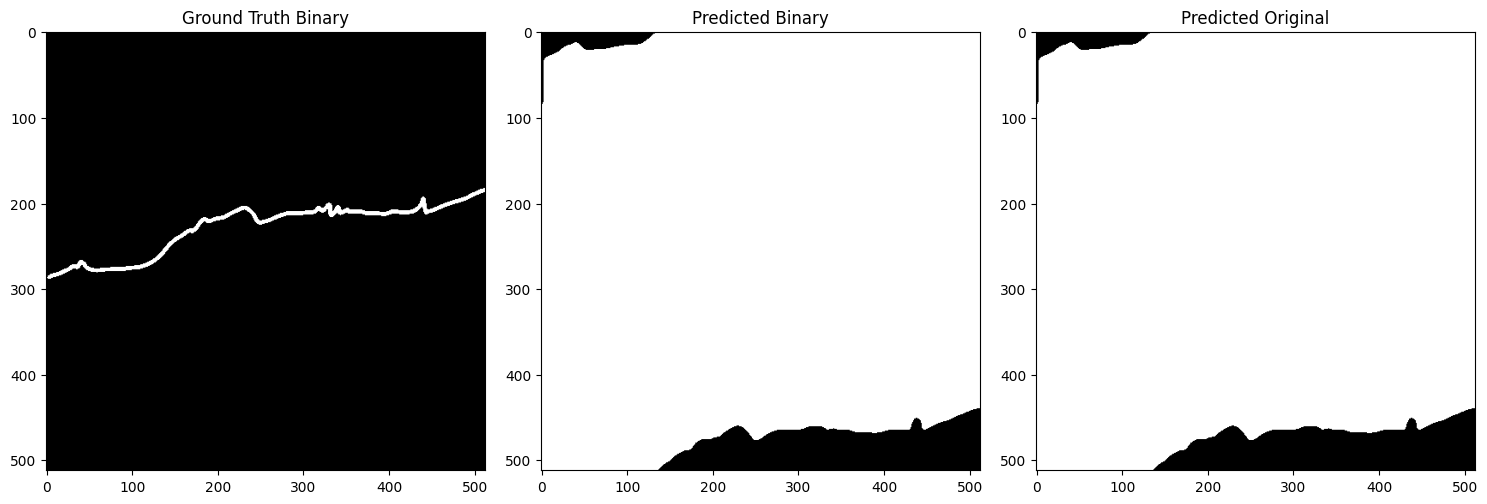

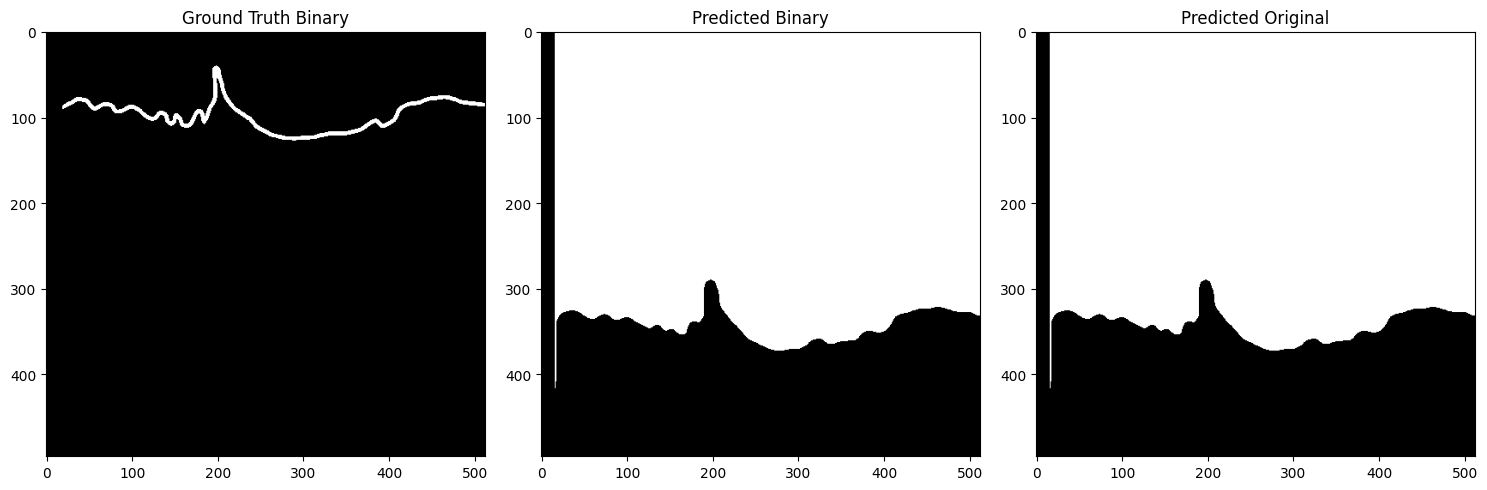

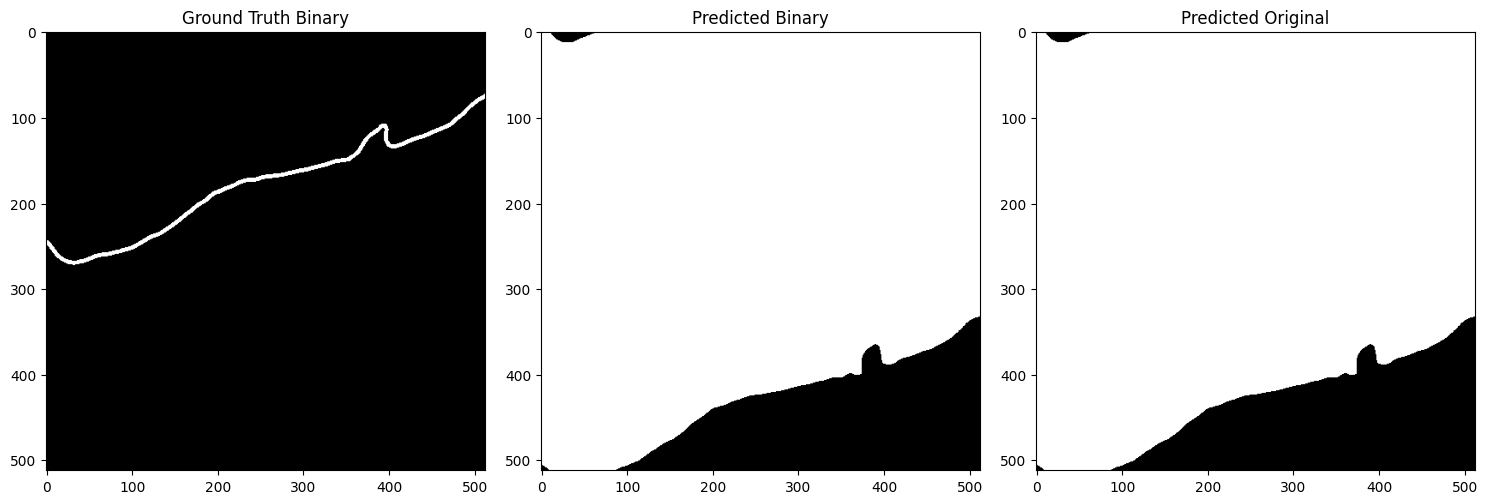

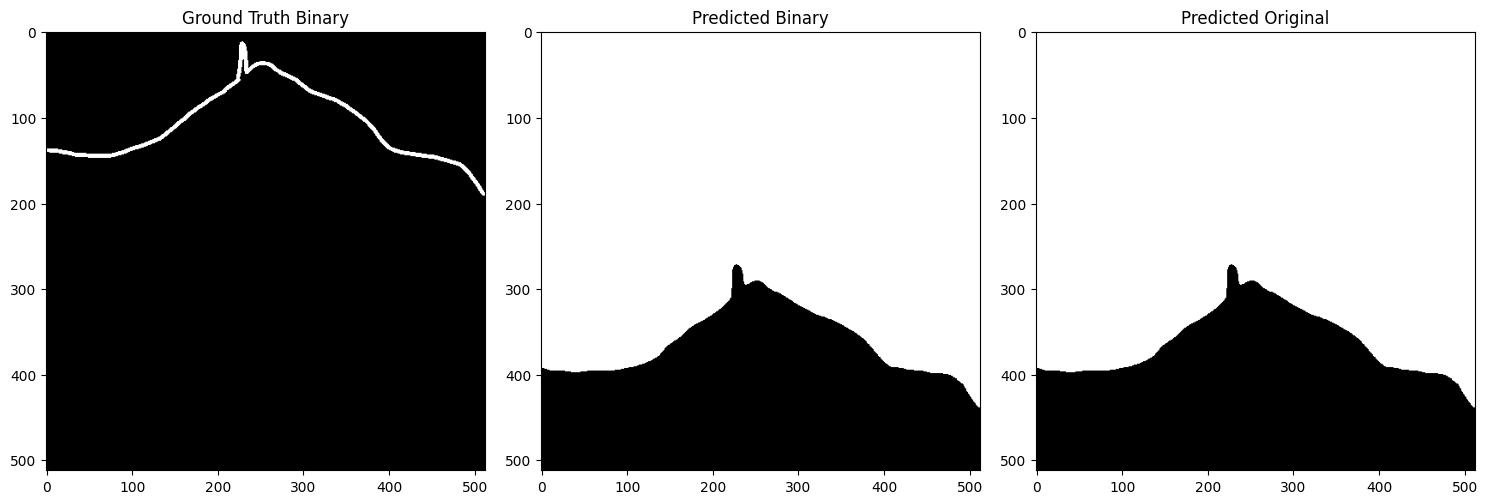

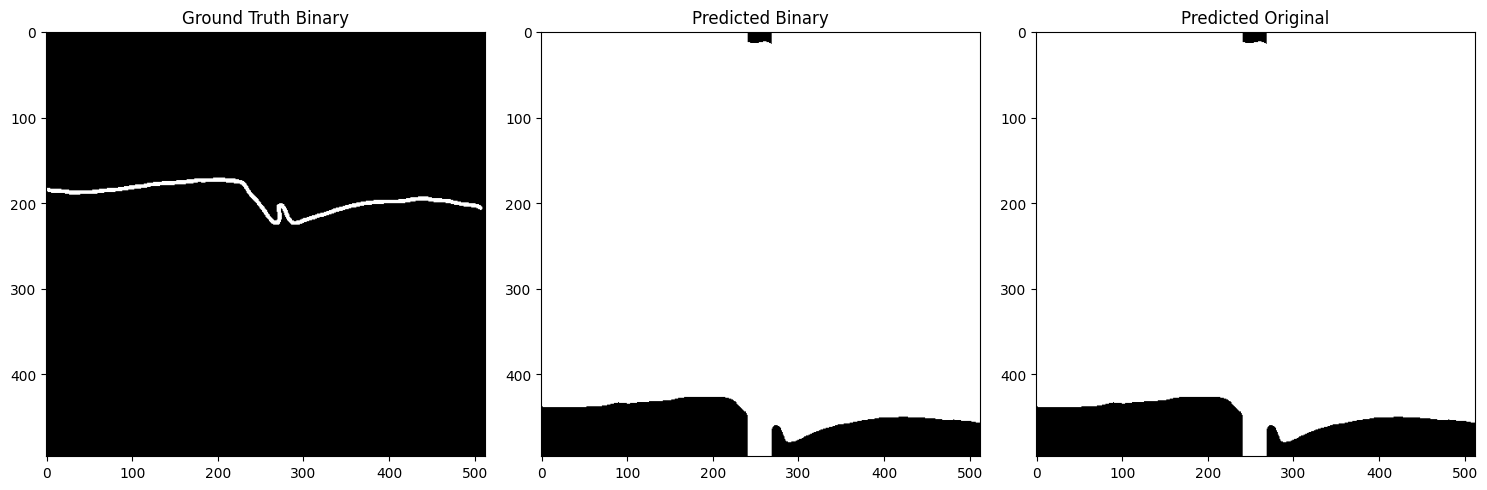

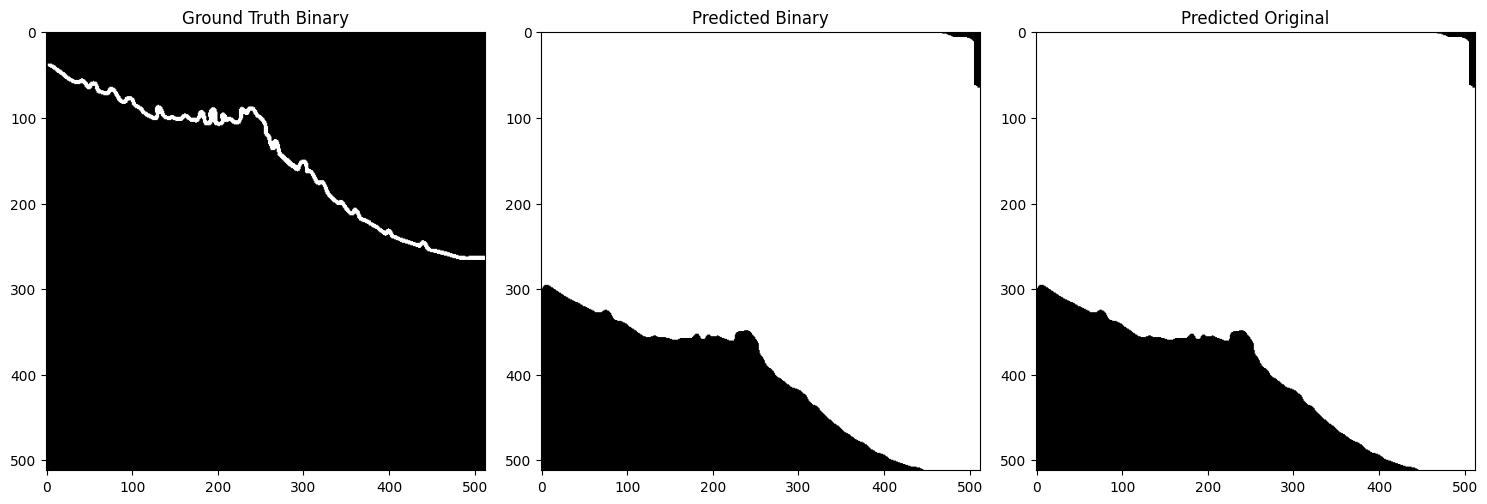

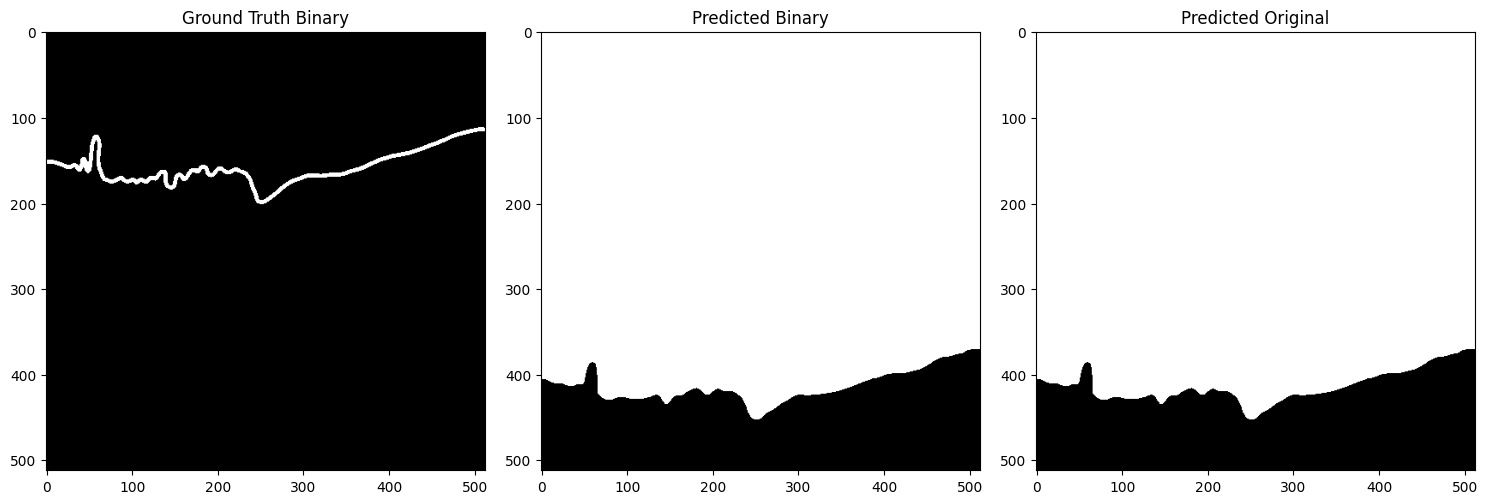

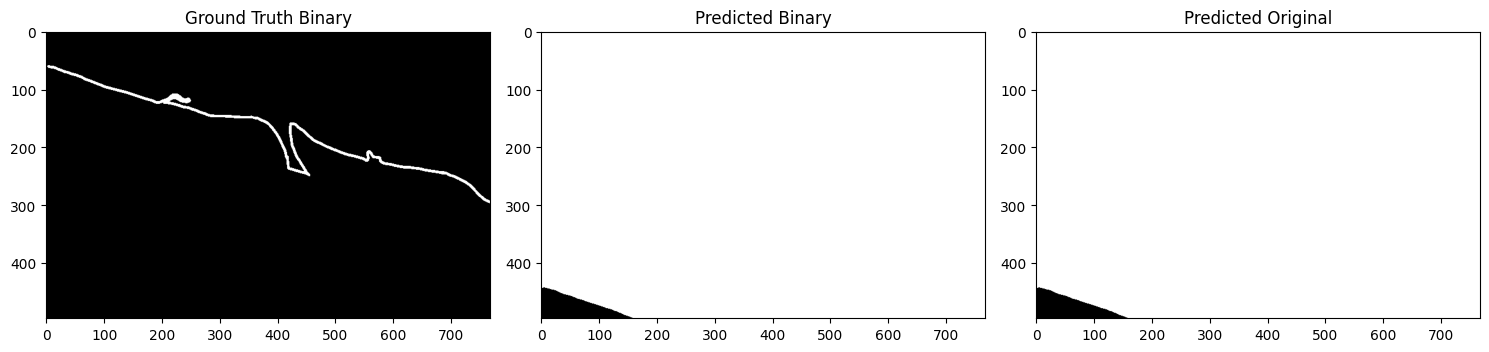

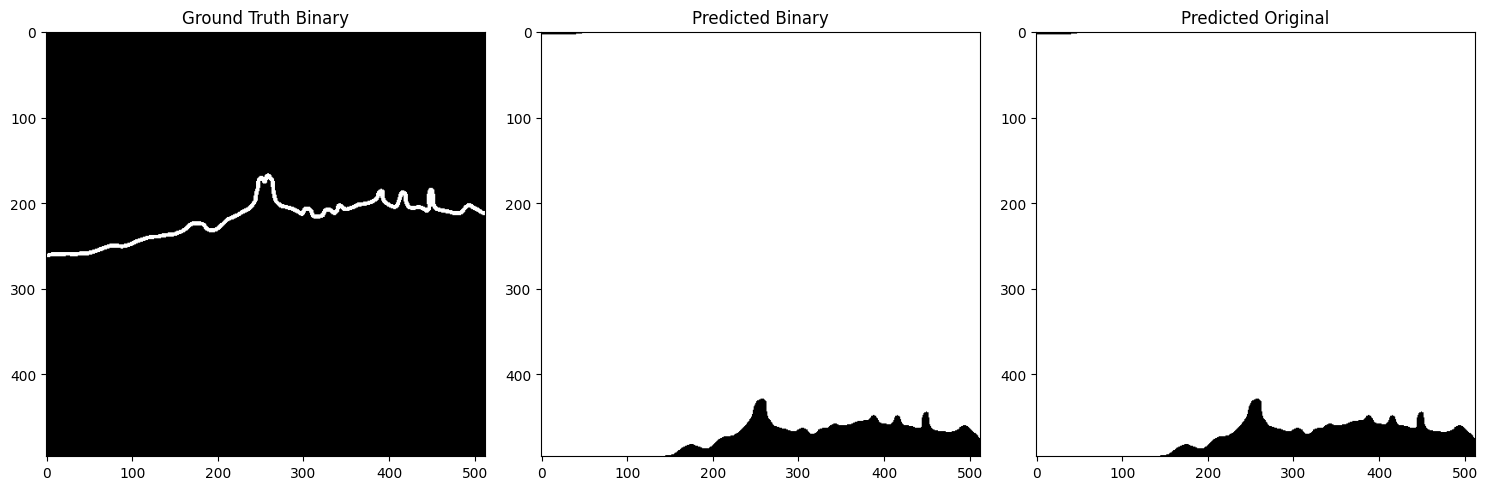

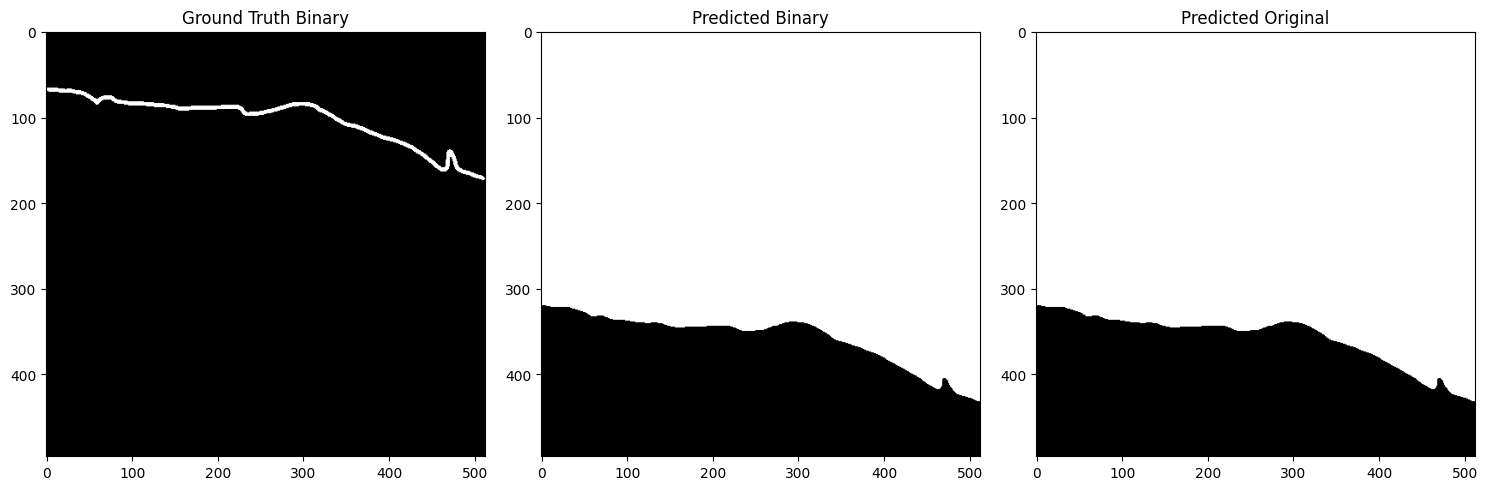

Average F1 Score: 0.03


In [49]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.metrics import f1_score

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")
    
    # Replace white pixels with black
    image[image > 250] = 0
    
    # Detect and remove white borders
    _, thresh = cv2.threshold(image, 240, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    non_white_pixels = np.where(thresh < 240)

    if non_white_pixels[0].size == 0 or non_white_pixels[1].size == 0:
        raise ValueError("No relevant pixels found in the image.")

    # Crop image to non-white pixels
    y_min, y_max = np.min(non_white_pixels[0]), np.max(non_white_pixels[0])
    x_min, x_max = np.min(non_white_pixels[1]), np.max(non_white_pixels[1])
    image = image[y_min:y_max+1, x_min:x_max+1]

    # Apply noise reduction
    image_denoised = cv2.fastNlMeansDenoising(
        cv2.bilateralFilter(
            cv2.medianBlur(image, 5), 9, 75, 75
        ), h=30
    )

    # Apply wavelet denoising
    coeffs = pywt.wavedec2(image_denoised, 'db1', level=2)
    coeffs[1:] = [tuple(pywt.threshold(i, value=10, mode='soft') for i in level) for level in coeffs[1:]]
    image_wavelet_denoised = pywt.waverec2(coeffs, 'db1')

    # Normalize and expand dimensions
    image_wavelet_denoised = np.expand_dims(image_wavelet_denoised, axis=(0, -1)).astype('float32') / 255.0
    return image, image_wavelet_denoised

def binary_mask(image):
    # Convert to uint8, apply Gaussian blur, and binary thresholding
    image_uint8 = (image * 255).astype(np.uint8).squeeze()
    blurred_image = cv2.GaussianBlur(image_uint8, (5, 5), 0)
    _, binary_image = cv2.threshold(blurred_image, 62.5, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def canny_edge_detection(image):
    return cv2.Canny(image, 100, 200)

def extract_highest_y(edges):
    height, width = edges.shape
    highest_y_values = np.full(width, height)  # Initialize with bottom of image

    for x in range(width):
        column = edges[:, x]
        y_indices = np.where(column > 0)[0]
        if y_indices.size > 0:
            highest_y_values[x] = y_indices.min()
    
    return highest_y_values

def calculate_thickness_via_morphology(ground_truth_image):
    # Convert to binary if not already
    _, binary_image = cv2.threshold(ground_truth_image, 127, 255, cv2.THRESH_BINARY)
    
    # Use dilation to estimate thickness
    kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size if needed
    dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
    
    # Find contours and estimate thickness
    contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    thicknesses = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        thicknesses.append(max(w, h))
    
    return max(1, int(np.mean(thicknesses)))  # Ensure thickness is at least 1

def plot_highest_y_on_edges(edges, highest_y_values, ground_truth_image):
    # Create an output image with the same dimensions as the input edges
    output_image = np.zeros_like(edges)
    
    # Calculate dynamic thickness based on ground truth
    base_thickness = calculate_thickness_via_morphology(ground_truth_image)  # Use any of the thickness calculation methods
    
    # Iterate through each x-coordinate
    for x, y in enumerate(highest_y_values):
        if y < edges.shape[0]:
            # Draw a thicker line by using a thicker line width
            start_y = max(0, y - base_thickness // 2)
            end_y = min(edges.shape[0], y + base_thickness // 2 + 1)
            output_image[start_y:end_y, x] = 255
    
    return output_image



def concatenate_paths(base_path, filenames):
    return [os.path.join(base_path, filename) for filename in filenames]

def pad_to_size(image, target_shape):
    target_height, target_width = target_shape
    height, width = image.shape[:2]

    # Create a canvas with target size and place the image in the center
    padded_image = np.zeros((target_height, target_width), dtype=np.uint8)
    top = (target_height - height) // 2
    left = (target_width - width) // 2
    padded_image[top:top + height, left:left + width] = image

    return padded_image

def calculate_f1_score(ground_truth_image, predicted_image):
    _, ground_truth_binary = cv2.threshold(ground_truth_image, 127, 255, cv2.THRESH_BINARY)
    _, predicted_binary = cv2.threshold(predicted_image, 127, 255, cv2.THRESH_BINARY)

    # Visualize for debugging
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(ground_truth_binary, cmap='gray')
    axs[0].set_title('Ground Truth Binary')
    axs[0].axis('on')

    axs[1].imshow(predicted_binary, cmap='gray')
    axs[1].set_title('Predicted Binary')
    axs[1].axis('on')

    axs[2].imshow(predicted_image, cmap='gray')
    axs[2].set_title('Predicted Original')
    axs[2].axis('on')

    plt.tight_layout()
    plt.show()

    return f1_score(ground_truth_binary.flatten(), predicted_binary.flatten(), pos_label=255, average='binary')

def process_and_visualize_images(test_image_paths, eval_image_paths):
    

    # for i in range(4,13):

        f1_scores = []

        for test_image_path, eval_image_path in zip(test_image_paths, eval_image_paths):
            # Preprocess the image
            original_image, preprocessed_image = preprocess_image(test_image_path)
            binary_image = binary_mask(preprocessed_image)
            edges = canny_edge_detection(binary_image)
            highest_y_values = extract_highest_y(edges)
            highest_y_image = plot_highest_y_on_edges(edges, highest_y_values, ground_truth_image = cv2.imread(eval_image_path, cv2.IMREAD_GRAYSCALE))
            

            # Load ground truth image
            ground_truth_image = cv2.imread(eval_image_path, cv2.IMREAD_GRAYSCALE)
            if ground_truth_image is None:
                raise FileNotFoundError(f"Ground truth image at path {eval_image_path} not found.")

            # Pad images to ensure the same size
            max_height = max(ground_truth_image.shape[0], highest_y_image.shape[0])
            max_width = max(ground_truth_image.shape[1], highest_y_image.shape[1])

            ground_truth_padded = pad_to_size(ground_truth_image, (max_height, max_width))
            top_line_padded = pad_to_size(highest_y_image, (max_height, max_width))

            # Calculate F1 score
            f1 = calculate_f1_score(ground_truth_padded, top_line_padded)
            f1_scores.append(f1)

            # # Plot results
            # fig, axs = plt.subplots(1, 3, figsize=(25, 5))
            # axs[0].imshow(top_line_padded, cmap='gray')
            # axs[0].set_title('Top Line')
            # axs[0].text(10, 20, f'F1: {f1:.2f}', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
            # axs[0].axis('on')

            # axs[1].imshow(ground_truth_padded, cmap='gray')
            # axs[1].set_title('Ground Truth')
            # axs[1].axis('on')

            # axs[2].imshow(highest_y_image, cmap='gray')
            # axs[2].set_title('Highest Y Values')
            # axs[2].axis('on')

            # plt.show()

        # Print the average F1 score
        
        print(f"Average F1 Score: {np.mean(f1_scores):.2f}")

# Example usage
test_base_path = 'DATA_OCT'
eval_base_path1 = 'BOOM_ILM'

test_filenames = [
    'dr_test_1190_NV.jpg', 'img_02.jpeg', 'img_04.jpeg',
    'img_05.jpeg', 'img_06.jpeg', 'img_07.jpeg',
    'img_08.jpeg', 'img_09.jpeg', 'img_10.jpeg',
    'img_11.jpeg', 'img_15.jpeg', 'img_16.jpeg',
    'img_17.jpeg', 'img_18.jpeg', 'img_19.jpeg',
    'img_21.jpeg', 'img_23.jpeg', 'img_24.jpeg',
    'img_25.jpeg'
]

eval_filenamesBoom = [
    'dr_test_1190_NV.png', 'img_02.png', 'img_04.png',
    'img_05.png', 'img_06.png', 'img_07.png',
    'img_08.png', 'img_09 (1).PNG', 'img_10.png',
    'img_11.png', 'img_15.png', 'img_16.png',
    'img_17.png', 'img_18.png', 'img_19.png',
    'img_21.png', 'img_23.png', 'img_24.png',
    'img_25.png'
]

test_image_paths = concatenate_paths(test_base_path, test_filenames)
eval_image_paths1 = concatenate_paths(eval_base_path1, eval_filenamesBoom)

process_and_visualize_images(test_image_paths, eval_image_paths1)
